<a href="https://colab.research.google.com/github/LenaVolzhina/playing-with-neural-networks/blob/master/DL_chapter_6_char_lever_generation_with_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Загружаю Довлатова

In [0]:
# https://e-libra.ru/read/168185-solo-na-undervude.html
text = """..."""

In [0]:
input_fname_orig = 'dovlatov_ibm_orig.txt'

# with open(input_fname_orig, 'w') as fout:
#   fout.write(text)

with open(input_fname_orig) as fin:
  text = fin.read()

Чищу от лишних символов

In [0]:
basic = set(['\n', ' ', '!', '"', "'", '(', ')', ',', '-', '.', ':', ';', '?',])
cyrillics = set(chr(i) for i in range(ord('А'), ord('я') + 1)) | {'ё'}
alphabet = basic | cyrillics

In [7]:
text_chars = set(text)
print("Deleting", sorted(text_chars - alphabet))

Deleting ['0', '1', '2', '3', '4', '5', '6', '8', '9', '>', '`', 'a', 'b', 'c', 'g', 'i', 'm', 'n', 'o', 'p', 'r', 't', '«', '»', '–', '“', '„', '…', '₽']


In [0]:
text_clean = text
for char in text_chars - alphabet:
  text_clean = text_clean.replace(char, '')

In [9]:
len(text), len(text_clean)

(60727, 59750)

In [0]:
input_fname = 'dovlatov_ibm.txt'

with open(input_fname, 'w') as fout:
  fout.write(text_clean)

# Читаю и преобразовываю текст

In [0]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [12]:
START_CHAR = '\b'
END_CHAR = '\t'
PADDING_CHAR = '\a'

chars = set( [START_CHAR, '\n', END_CHAR] )
with open(input_fname) as f:
  for line in f:
    chars.update( list(line.strip().lower()) )

char_indices = { c : i for i, c in enumerate(sorted(list(chars))) }
print(repr(sorted(list(chars))[0]))
char_indices[PADDING_CHAR] = 0    # а то, что раньше было 0, куда?
indices_to_chars = { i : c for c,i in char_indices.items() }
num_chars = len(chars)

'\x08'


In [13]:
indices_to_chars

{0: '\x07',
 1: '\t',
 2: '\n',
 3: ' ',
 4: '!',
 5: '"',
 6: '(',
 7: ')',
 8: ',',
 9: '-',
 10: '.',
 11: ':',
 12: '?',
 13: 'а',
 14: 'б',
 15: 'в',
 16: 'г',
 17: 'д',
 18: 'е',
 19: 'ж',
 20: 'з',
 21: 'и',
 22: 'й',
 23: 'к',
 24: 'л',
 25: 'м',
 26: 'н',
 27: 'о',
 28: 'п',
 29: 'р',
 30: 'с',
 31: 'т',
 32: 'у',
 33: 'ф',
 34: 'х',
 35: 'ц',
 36: 'ч',
 37: 'ш',
 38: 'щ',
 39: 'ъ',
 40: 'ы',
 41: 'ь',
 42: 'э',
 43: 'ю',
 44: 'я'}

In [0]:
def get_one(i, sz):
  res = np.zeros(sz)
  res[i] = 1
  return res

char_vectors = {
  c : (np.zeros(num_chars) if c == PADDING_CHAR else get_one(v, num_chars))
  for c,v in char_indices.items()
}

In [0]:
# read sentences

sentence_end_markers = set( '.!?' )

sentences = []
current_sentence = ''
with open( input_fname, 'r' ) as f:
  for line in f:
    s = line.strip().lower()
    if len(s) > 0:
      current_sentence += s + '\n'
    if len(s) == 0 or s[-1] in sentence_end_markers:
      current_sentence = current_sentence.strip()
      if len(current_sentence) > 10:
        sentences.append(current_sentence)
      current_sentence = ''

In [16]:
sentences[102]

'трудная книга. но хорошая. говорят.'

(array([256., 139.,  91.,  29.,  18.,   8.,   2.,   3.,   0.,   2.]),
 array([ 11. ,  73.9, 136.8, 199.7, 262.6, 325.5, 388.4, 451.3, 514.2,
        577.1, 640. ]),
 <a list of 10 Patch objects>)

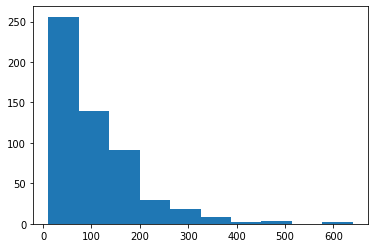

In [17]:
sentence_lengths = np.array([len(s) for s in sentences])
plt.hist(sentence_lengths)

In [0]:
# vectorize

def get_matrices(sentences):
  max_sentence_len = np.max([ len(x) for x in sentences ])
  X = np.zeros((len(sentences), max_sentence_len, len(chars)), dtype=np.bool)
  y = np.zeros((len(sentences), max_sentence_len, len(chars)), dtype=np.bool)
  for i, sentence in enumerate(sentences):
    char_seq = (START_CHAR + sentence + END_CHAR).ljust(
      max_sentence_len+1, PADDING_CHAR    # заполняем до "конца"
    )
    for t in range(max_sentence_len):
      X[i, t, :] = char_vectors[char_seq[t]]
      y[i, t, :] = char_vectors[char_seq[t+1]]
  return X,y

# Строим простую модель: один уровень LSTM-ячеек

## Описываем модель

In [19]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, TimeDistributed, Activation

model = Sequential()
model.add(LSTM(
  output_dim=128,   # слой состоит из 128 ячеек, оно же размерность выхода
  activation='tanh',  # по умолчанию сигмоида
  return_sequences=True, # выдавать выходы после каждого примера, 
                         # а не после всей посоедовательности
  input_dim=num_chars   # размерность входного вектора для одного символа
))

# дропаут в RNN -- дело тонкое
# обычно только между слоями, не внутри ячейки. но сейчас мнение сдвигается
# пока ограничимся обычным, между слоями, обсудим позже
model.add(Dropout(0.2))

# одни и те же веса по всей длине входной последовательности (shared weights)
model.add(TimeDistributed(Dense(output_dim=num_chars)))
model.add(Activation('softmax'))

Using TensorFlow backend.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(activation="tanh", return_sequences=True, input_shape=(None, 45), units=128)`
  # Remove the CWD from sys.path while we load stuff.



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=45)`


## Оптимизация

Чтобы градиенты в рекуррентной сети не взрывались, их обязательно нужно купировать, обрезать до некоторого максимально допустимого размера (по-английски это называется gradient clipping)

* clipnorm будет масштабировать вектор градиента так, чтобы его норма не превысила заданного порога;
* clipvalue будет просто обрезать до заданного порога каждую компоненту градиента по отдельности.

In [20]:
from keras.optimizers import Adam

model.compile(
  loss='categorical_crossentropy',
  optimizer=Adam(clipnorm=1.), 
  metrics=['accuracy']
)

## Генерация батчей

В порядке возрастания длины предложения

In [0]:
test_indices = np.random.choice(range(len(sentences)), int(len(sentences) * 0.05))
sentences_train = [
  sentences[x]
  for x in set(range(len(sentences))) - set(test_indices) 
]
sentences_test = [sentences[x] for x in test_indices]
sentences_train = list(sorted(sentences_train, key = lambda x : len(x)))
X_test, y_test = get_matrices(sentences_test)

batch_size = 16

def generate_batch():
  while True:
    for i in range( int(len(sentences_train) / batch_size) ):
      sentences_batch = sentences_train[ i*batch_size : (i+1)*batch_size ]
      yield get_matrices(sentences_batch)

## Сэмплер примеров

In [0]:
import os
from keras.callbacks import Callback


class CharSampler(Callback):
  def __init__(self, char_vectors, model, output_fname, step):
    self.char_vectors = char_vectors
    self.model = model
    self.output_fname = output_fname
    self.step = step

  def on_train_begin(self, logs={}):
    self.epoch = 0
    if os.path.isfile(self.output_fname):
      os.remove(self.output_fname)

  def sample(self, preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

  def sample_one(self, T):
    # get one sentence
    result = START_CHAR
    while len(result) < 500:
      Xsampled = np.zeros( (1, len(result), num_chars) )
      for t, c in enumerate( list( result ) ):
        Xsampled[0,t,:] = self.char_vectors[ c ]
      ysampled = self.model.predict( Xsampled, batch_size=1 )[0,:]
      yv = ysampled[len(result)-1,:]
      selected_char = indices_to_chars[ self.sample( yv, T ) ]
      if selected_char == END_CHAR:
        break
      result = result + selected_char
    return result

  def on_epoch_end(self, batch, logs={}):
    self.epoch = self.epoch + 1
    if self.epoch % self.step == 0:
      print("\nEpoch %d text sampling:" % self.epoch)
      with open( self.output_fname, 'a' ) as outf:
        outf.write( '\n===== Epoch %d =====\n' % self.epoch )
        for T in [0.3, 0.5, 0.7, 0.9, 1.1]:
          print('\tsampling, T = %.1f...' % T)
          for _ in range(5):
            self.model.reset_states()
            res = self.sample_one(T)
            outf.write( '\nT = %.1f\n%s\n' % (T, res[1:]) )

### Callbacks

In [0]:
from datetime import datetime
from keras.callbacks import ModelCheckpoint, CSVLogger

filename = "simple_model_{}.log"

cb_sampler = CharSampler(char_vectors, model, filename.format('sampler'), step=5)
cb_logger = CSVLogger(filename.format('csv'))
cb_checkpoint = ModelCheckpoint(filename.format('val_loss'), monitor='val_loss') #, verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)

## Обучаем!

In [30]:
model.fit_generator(
  generate_batch(),
  int(len(sentences_train) / batch_size) * batch_size,   # объем X
  nb_epoch=50, verbose=True, 
  validation_data = (X_test, y_test),
  callbacks=[cb_logger, cb_sampler]#, cb_checkpoint] 
)

Epoch 1/50
  3/512 [..............................] - ETA: 19s - loss: 2.6294 - acc: 0.1977

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., 512, verbose=True, validation_data=(array([[[..., callbacks=[<keras.ca..., epochs=50)`
  


512/512 [==============================] - 58s 114ms/step - loss: 2.4522 - acc: 0.2509 - val_loss: 0.4692 - val_acc: 0.0539
Epoch 2/50
512/512 [==============================] - 58s 114ms/step - loss: 2.2532 - acc: 0.3037 - val_loss: 0.4536 - val_acc: 0.0586
Epoch 3/50
512/512 [==============================] - 60s 117ms/step - loss: 2.0951 - acc: 0.3512 - val_loss: 0.4487 - val_acc: 0.0615
Epoch 4/50
512/512 [==============================] - 59s 115ms/step - loss: 1.9508 - acc: 0.3944 - val_loss: 0.4579 - val_acc: 0.0600
Epoch 5/50
512/512 [==============================] - 59s 115ms/step - loss: 1.8069 - acc: 0.4374 - val_loss: 0.4738 - val_acc: 0.0576

Epoch 5 text sampling:
	sampling, T = 0.3...
	sampling, T = 0.5...
	sampling, T = 0.7...
	sampling, T = 0.9...
	sampling, T = 1.1...
Epoch 6/50
512/512 [==============================] - 60s 117ms/step - loss: 1.6898 - acc: 0.4708 - val_loss: 0.4739 - val_acc: 0.0592
Epoch 7/50
512/512 [==============================] - 60s 118ms/ste

In [31]:
with open('simple_model_sampler.log') as fin:
  print(fin.read())


===== Epoch 5 =====

T = 0.3
с посторьше была тоть к пристве не догоденсимает провоский молодице. не сыватиль кам ту реду. постора в провом отнити продовом была не постросивать в пестернов меня.

T = 0.3
сказал:
тоненого вы спрашивает:
на петеве не зазнотом не зазнимать вы подели в деловек.

T = 0.3
да мое тобеда та просил севнесь даль е теме не зазалитесь еста. и несказал в простой. в ответ просомойного сельше говорю.

T = 0.3
пристоло и не была так его вылсял стали м разаные.

T = 0.3
на чимо реднакова верехо обы зались деле не просторил сказал:
мы вышь поэто мниного спросила тетедна. он был дела не притволиль не зазамные такатова.

T = 0.5
удиль молодим белетповил мольной капрова вселивать каз кат.

T = 0.5
разве ты дрематург?!

T = 0.5
тот каканали  пидела дого причемола не прастиласть не подникова северий в простой. примелал с половочество в семен. не однето протеси. тогда вы вого на драгорасть мереже заманить в пестурьнин левно прокому: веряель в ответ прозвестенинов ручелинь мо

# Сложнее
Однако будет лучше (внимание: это важный трюк в построении глубоких рекуррентных сетей!), если последующему слою подать на вход не только результат предыдущего, но и собственно входную последовательность; такая конструкция называется **skip-layer connection (связь с пропуском слоя)**.

In [36]:
from keras.layers import concatenate, Input
from keras.models import Model

# input-1
vec = Input(shape=(None, num_chars))
l1 = LSTM(output_dim=128, activation='tanh', return_sequences=True)(vec)
l1_d = Dropout(0.2)(l1)

# input-2 = input-1 || output-1
input2 = concatenate([vec, l1_d], axis=-1)
l2 = LSTM(output_dim=128, activation='tanh', return_sequences=True)(input2)
l2_d = Dropout(0.2)(l2)

# input-3 = input-1 || output-2
input3 = concatenate([vec, l2_d], axis=-1)
l3 = LSTM(output_dim=128, activation='tanh', return_sequences=True)(input3)
l3_d = Dropout(0.2)(l3)

# input-dense = output-1 || output-2 || output-3
input_d = concatenate([l1_d, l2_d, l3_d], axis=-1)
dense3 = TimeDistributed(Dense(output_dim=num_chars))(input_d)
output_res = Activation('softmax')(dense3)

model = Model(input=vec, output=output_res)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(activation="tanh", return_sequences=True, units=128)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(activation="tanh", return_sequences=True, units=128)`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(activation="tanh", return_sequences=True, units=128)`
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=45)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ac...)`


In [0]:
from keras.optimizers import Adam

model.compile(
  loss='categorical_crossentropy',
  optimizer=Adam(clipnorm=1.), 
  metrics=['accuracy']
)

In [0]:
filename = "complex_model_{}.log"

cb_sampler = CharSampler(char_vectors, model, filename.format('sampler'), step=5)
cb_logger = CSVLogger(filename.format('csv'))

In [40]:
model.fit_generator(
  generate_batch(),
  int(len(sentences_train) / batch_size) * batch_size,   # объем X
  nb_epoch=50, verbose=True, 
  validation_data = (X_test, y_test),
  callbacks=[cb_logger, cb_sampler]
)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., 512, verbose=True, validation_data=(array([[[..., callbacks=[<keras.ca..., epochs=50)`
  


Epoch 1/50
512/512 [==============================] - 201s 393ms/step - loss: 2.5955 - acc: 0.2286 - val_loss: 0.4574 - val_acc: 0.0592
Epoch 2/50
512/512 [==============================] - 200s 391ms/step - loss: 2.0893 - acc: 0.3469 - val_loss: 0.4318 - val_acc: 0.0661
Epoch 3/50
512/512 [==============================] - 201s 393ms/step - loss: 1.7425 - acc: 0.4516 - val_loss: 0.4422 - val_acc: 0.0651
Epoch 4/50
512/512 [==============================] - 201s 393ms/step - loss: 1.4395 - acc: 0.5435 - val_loss: 0.4686 - val_acc: 0.0639
Epoch 5/50
512/512 [==============================] - 200s 392ms/step - loss: 1.1960 - acc: 0.6150 - val_loss: 0.4973 - val_acc: 0.0645

Epoch 5 text sampling:
	sampling, T = 0.3...
	sampling, T = 0.5...
	sampling, T = 0.7...
	sampling, T = 0.9...
	sampling, T = 1.1...
Epoch 6/50
512/512 [==============================] - 201s 392ms/step - loss: 1.0052 - acc: 0.6691 - val_loss: 0.5264 - val_acc: 0.0627
Epoch 7/50
512/512 [==============================

KeyboardInterrupt: ignored

In [41]:
with open('complex_model_sampler.log') as fin:
  print(fin.read())


===== Epoch 5 =====

T = 0.3
в ответ прозвучало:
привет, адольф!

T = 0.3
да, я фронтовик.

T = 0.3
тогда я сейчас вернусь. вос поприлиниц криковуки себиделся обрательно сказал:
мом были евь. и на деле не ответил:
одна же погде не все тратве проковались и я будетули мо себераним отразился на были за болакого. поворил белогов и ветул и проворил обнать ленина. продела теля на прашева. обрать в одноманти они пойдетел лостань в там середал молодов и вольфе шил неце деть. молодов говорил:
ени его обинил за костинил виковил они пожелиста.

T = 0.3
я с брайте доблавал в этом тро как и содился в двалиний. и тобе долого спрашивает:
том совешь накомил и того разницайтенный соморни. попросил его не голько стали бы вас пошказ день родуки.

T = 0.3
так вот жених  от нах. дель и удакавился:
кареше в ответ привесил:
и того вы ленительно соредиковора наповали в твентих крахтарант.

T = 0.5
как вас постричь?

T = 0.5
не пойду,  говорит,  какой-то он советский.

T = 0.5
когда ты хороша ? глядин так нач